In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split as sk_split
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from tqdm.notebook import tqdm

## Загрузка данных

In [221]:
ratings = pd.read_csv("goodbooks-10k/ratings.csv")
books = pd.read_csv("goodbooks-10k/books.csv")
tags = pd.read_csv("goodbooks-10k/tags.csv")
book_tags = pd.read_csv("goodbooks-10k/book_tags.csv")

In [222]:
datasets = {
    "ratings": ratings, 
    "books": books, 
    "tags": tags, 
    "book_tags": book_tags
}

for name, df in datasets.items():
    print(f"{name}: {df.shape}")


ratings: (5976479, 3)
books: (10000, 23)
tags: (34252, 2)
book_tags: (999912, 3)


# Этап 1: знакомство с данными и EDA

## 1.1 Что представляют из себя данные

In [223]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB


In [224]:
ratings.head(5)

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [225]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

In [226]:
books['original_title'] = books['original_title'].fillna(books['title'])
books.head(5)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [227]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34252 entries, 0 to 34251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tag_id    34252 non-null  int64 
 1   tag_name  34252 non-null  object
dtypes: int64(1), object(1)
memory usage: 535.3+ KB


In [228]:
tags.head(5)

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [229]:
book_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999912 entries, 0 to 999911
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   goodreads_book_id  999912 non-null  int64
 1   tag_id             999912 non-null  int64
 2   count              999912 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB


In [230]:
book_tags.head(5)

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


## 1.2 Распределение оценок

Проверим есть ли смещение в оценках:

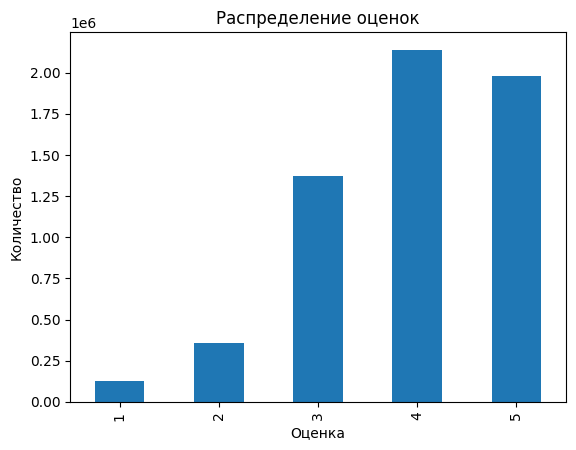

In [231]:
ratings['rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Оценка")
plt.ylabel("Количество")
plt.title("Распределение оценок")
plt.show()

Наблюдается смещеное в сторону высоких оценок.

## 1.3 Активность пользователей

Посмотрим на взаимоотношение количества пользователей и количества оценок

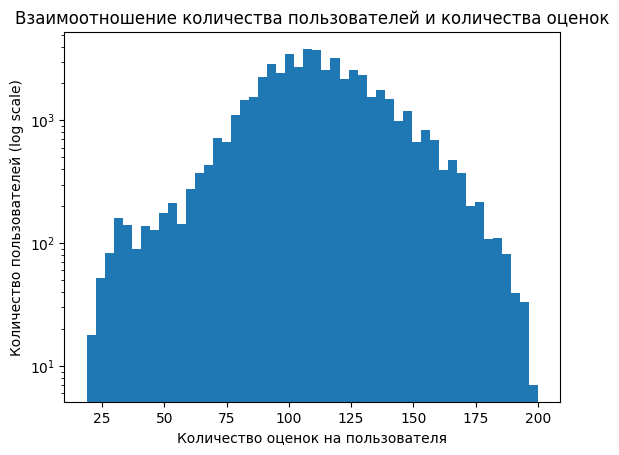

In [232]:
user_activity = ratings.groupby('user_id')['rating'].count()

user_activity.plot(kind='hist', bins=50, log=True)
plt.xlabel("Количество оценок на пользователя")
plt.ylabel("Количество пользователей (log scale)")
plt.title("Взаимоотношение количества пользователей и количества оценок")
plt.show()

Большинство пользователей оставили мало оценок, небольшое количество активных пользователей.

In [233]:
print("Статистика активности пользователей:")
print(f"Общее количество пользователей: {len(user_activity)}")
print(f"Среднее количество оценок на пользователя: {user_activity.mean():.2f}")
print(f"Медианное количество оценок на пользователя: {user_activity.median()}")
print(f"Минимальное количество оценок на пользователя: {user_activity.min()}")
print(f"Максимальное количество оценок на пользователя: {user_activity.max()}")
print(f"Пользователи с < 30 оценками: {(user_activity < 30).sum()} ({(user_activity < 30).sum()/len(user_activity)*100:.1f}%)")

Статистика активности пользователей:
Общее количество пользователей: 53424
Среднее количество оценок на пользователя: 111.87
Медианное количество оценок на пользователя: 111.0
Минимальное количество оценок на пользователя: 19
Максимальное количество оценок на пользователя: 200
Пользователи с < 30 оценками: 153 (0.3%)


In [234]:
# Самые активные (топ по количеству оценок)
print("Топ активных пользователей:")
print(user_activity.sort_values(ascending=False).head(10))

# Холодный старт (минимум взаимодействий)
print("\nПользователи с минимальной активностью:")
print(user_activity.sort_values(ascending=True).head(10))

Топ активных пользователей:
user_id
30944    200
12874    200
52036    199
12381    199
28158    199
45554    197
6630     197
15604    196
37834    196
19729    196
Name: rating, dtype: int64

Пользователи с минимальной активностью:
user_id
34590    19
43675    20
40753    21
51725    21
32128    21
37640    22
16470    22
42736    22
48077    22
40299    22
Name: rating, dtype: int64


## 1.4 Популярность книг

Посмотрим на отношение количества книг против количества оценок

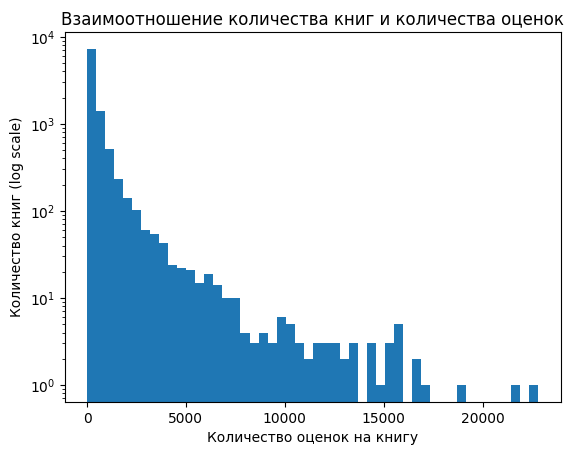

In [235]:
book_popularity = ratings.groupby('book_id')['rating'].count()

book_popularity.plot(kind='hist', bins=50, log=True)
plt.xlabel("Количество оценок на книгу")
plt.ylabel("Количество книг (log scale)")
plt.title("Взаимоотношение количества книг и количества оценок")
plt.show()

In [236]:
print("Статистика популярности книг:")
print(f"Всего книг: {len(book_popularity)}")
print(f"Медиана оценок на книгу: {book_popularity.median()}")
print(f"Среднее оценок на книгу: {book_popularity.mean()}")
print(f"Минимальное количество оценок: {book_popularity.min()}")
print(f"Максимальное количество оценок: {book_popularity.max()}")

print(f"\nКниг с >= 1000 оценками: {(book_popularity >= 1000).sum()} ({(book_popularity >= 1000).sum()/len(book_popularity)*100:.1f}%)")
print(f"Книг с < 1000 оценками: {(book_popularity < 1000).sum()} ({(book_popularity < 1000).sum()/len(book_popularity)*100:.1f}%)")

Статистика популярности книг:
Всего книг: 10000
Медиана оценок на книгу: 248.0
Среднее оценок на книгу: 597.6479
Минимальное количество оценок: 8
Максимальное количество оценок: 22806

Книг с >= 1000 оценками: 1229 (12.3%)
Книг с < 1000 оценками: 8771 (87.7%)


Наблюдается небольшое число очень популярных книг (длинный хвост).

Большинство книг имеют мало оценок

Выведем ТОП-10 книг по популярности:

In [237]:
book_popularity = (
    ratings
    .groupby('book_id')
    .size()
    .reset_index(name='num_ratings')
)

top_books = (
    book_popularity
    .merge(books[['book_id', 'original_title']], on='book_id')
    .sort_values('num_ratings', ascending=False)
    .head(10)
)

top_books

,book_id,num_ratings,original_title
0,1,22806,The Hunger Games
1,2,21850,Harry Potter and the Philosopher's Stone
3,4,19088,To Kill a Mockingbird
2,3,16931,Twilight
4,5,16604,The Great Gatsby
16,17,16549,Catching Fire
19,20,15953,Mockingjay
17,18,15855,Harry Potter and the Prisoner of Azkaban
22,23,15657,Harry Potter and the Chamber of Secrets
6,7,15558,The Hobbit or There and Back Again


## 1.5 Теги

Посмотрим на популярные теги

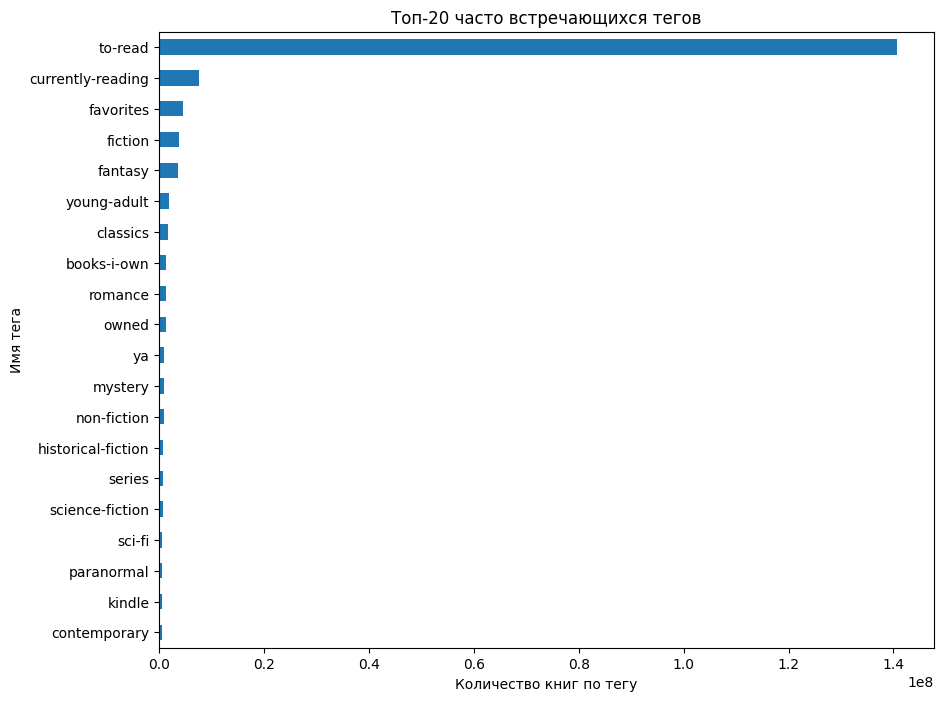

In [238]:
book_tags_merged = book_tags.merge(tags, on='tag_id')

top_tags = (
    book_tags_merged
    .groupby('tag_name')['count']
    .sum()
    .sort_values(ascending=False)
    .head(20)
)

top_tags.sort_values(ascending=True).plot(kind='barh', figsize=(10, 8))
plt.title("Топ-20 часто встречающихся тегов")
plt.xlabel("Количество книг по тегу")
plt.ylabel("Имя тега")
plt.show()

Удалим теги которые не отражают контент книги

In [239]:
excluded_tags = {"to-read", "currently-reading", "favorites"}

tags = tags[~tags['tag_name'].isin(excluded_tags)]

book_tags = book_tags.merge(
    tags[['tag_id']],
    on='tag_id',
    how='inner'
)

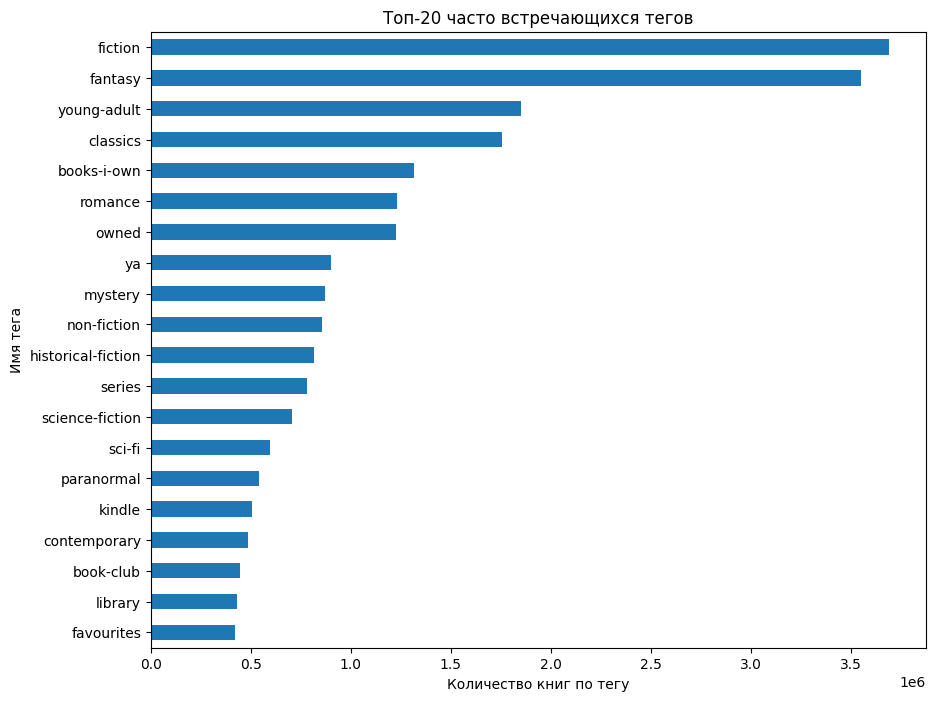

In [240]:
book_tags_merged = book_tags.merge(tags, on='tag_id')

top_tags = (
    book_tags_merged
    .groupby('tag_name')['count']
    .sum()
    .sort_values(ascending=False)
    .head(20)
)

top_tags.sort_values(ascending=True).plot(kind='barh', figsize=(10, 8))
plt.title("Топ-20 часто встречающихся тегов")
plt.xlabel("Количество книг по тегу")
plt.ylabel("Имя тега")
plt.show()

# 1.6 Основные проблемы данных

1. Разреженность. Каждый пользователь оценивает малую долю книг. Большинство пользователей оставили небольшое число оценок (хвост)

2. Смещение популярности. Распределение количества оценок по книгам неравномерно (длинный хвост). Небольшая группа книг получает больше внимания пользователей

3. Смещение оценок в сторону высоких значений

4. Значительная часть пользователей имеет мало взаимадойствий. Для них коллаборативные модели не применимы.


Уже на этапе EDA становится ясно, что ни один подход в одиночку не будет оптимальным. Это обосновывает использование нескольких моделей и гибридной рекомендательной системы в последующих этапах.

# Этап 2: базовые и контентные модели

## 2.1 Неперсонализированная модель

Алгоритм, возвращающий Top-N самых популярных книг (по среднему рейтингу с порогом минимального количества оценок).

In [241]:
MIN_RATINGS = 1000

# подсчёт статистик по книгам
book_stats = (
    ratings
    .groupby('book_id')
    .agg(
        mean_rating=('rating', 'mean'),
        num_ratings=('rating', 'count')
    )
    .reset_index()
)

# фильтрация по минимальному числу оценок
popular_books = book_stats[book_stats['num_ratings'] >= MIN_RATINGS]

# сортировка по среднему рейтингу
top_popular_books = (
    popular_books
    .sort_values('mean_rating', ascending=False)
)

# объединение с метаданными книг
top_popular_books = top_popular_books.merge(
    books[['book_id', 'original_title']],
    on='book_id'
)

In [242]:
# Функция рекомендаций Top-N
def get_top_popular_books(N=10):
    return top_popular_books.head(N)[
        ['book_id', 'original_title', 'mean_rating', 'num_ratings']
    ]

In [243]:
# Проверим
get_top_popular_books(N=10)

,book_id,original_title,mean_rating,num_ratings
0,862,Words of Radiance,4.702840,1373
1,780,Calvin and Hobbes,4.661406,1394
2,422,Complete Harry Potter Boxed Set,4.659530,1915
3,1010,The Essential Calvin and Hobbes: A Calvin and ...,4.652522,1249
4,1264,Queen of Shadows,4.564007,1078
5,562,The Way of Kings,4.545556,1789
6,25,Harry Potter and the Deathly Hallows,4.525941,15304
7,964,The Hobbit and The Lord of the Rings,4.518571,1400
8,192,The Name of the Wind,4.499747,3948
9,1022,Heir of Fire,4.484919,1293


## 2.2 Контентная модель

In [244]:
book_tags_merged = book_tags.merge(
    tags,
    on='tag_id',
    how='inner'
)

book_tags_merged = book_tags_merged.merge(
    books[['book_id', 'goodreads_book_id']],
    on='goodreads_book_id',
    how='inner'
)

# теги по книгам
book_tags_text = (
    book_tags_merged
    .groupby('book_id')['tag_name']
    .apply(lambda x: ' '.join(x))
    .reset_index()
)

# объединяем с данными о книгах
books_content = books[['book_id', 'original_title']].merge(
    book_tags_text,
    on='book_id',
    how='left'
)

# если у книги нет тегов - заменяем NaN пустой строкой
books_content['tag_name'] = books_content['tag_name'].fillna('')

# формирование текстового профиля книги
books_content['content_profile'] = (
    books_content['original_title'] + ' ' +
    books_content['tag_name']
)

# векторизация с помощью TF-IDF
tfidf = TfidfVectorizer(stop_words='english',max_features=20000)
tfidf_matrix = tfidf.fit_transform(books_content['content_profile'])

# матрица косинусной близости
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# индексация
book_id_to_idx = {
    book_id: idx
    for idx, book_id in enumerate(books_content['book_id'])
}
idx_to_book_id = {
    idx: book_id
    for book_id, idx in book_id_to_idx.items()
}

In [245]:
# Функция поиска похожих книг
def get_similar_books(book_id, N=10):
    if book_id not in book_id_to_idx:
        raise ValueError("ID книги не найден")

    idx = book_id_to_idx[book_id]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # исключаем саму книгу
    sim_scores = sim_scores[1:N+1]

    similar_book_ids = [idx_to_book_id[i] for i, _ in sim_scores]

    return books_content[
        books_content['book_id'].isin(similar_book_ids)
    ][['book_id', 'original_title']]


In [246]:
# пример
get_similar_books(book_id=1, N=10)

,book_id,original_title
11,12,Divergent
16,17,Catching Fire
19,20,Mockingjay
506,507,The Hunger Games Box Set
716,717,The Hunger Games: Official Illustrated Movie C...
1354,1355,The Hunger Games Tribute Guide
1819,1820,Hunger
2562,2563,Monsters of Men
6223,6224,The World of the Hunger Games (Hunger Games Tr...
8576,8577,The girl who was on fire


# Этап 3: коллаборативная фильтрация

In [247]:
# матрица взаимодействий пользователь - книга
user_item_matrix = ratings.pivot_table(
    index='user_id',
    columns='book_id',
    values='rating'
)
#user_item_filled = user_item_matrix.fillna(0)

book_mean_ratings = user_item_matrix.mean(axis=0)
user_item_centered = user_item_matrix.sub(book_mean_ratings, axis=1).fillna(0)

# схожесть
item_similarity = cosine_similarity(user_item_centered.T)
item_similarity_df = pd.DataFrame(
    item_similarity,
    index=user_item_matrix.columns,
    columns=user_item_matrix.columns
)

In [248]:
# Функция предсказания рейтинга
def predict_rating_item_cf(user_id, book_id, K=10):
    if book_id not in item_similarity_df.columns or user_id not in user_item_matrix.index:
        return None

    # все книги, которые пользователь оценил
    user_ratings = user_item_matrix.loc[user_id].dropna()
    if user_ratings.empty:
        return None

    # сходство книги book_id с оцененными книгами пользователя
    similarities = item_similarity_df[book_id][user_ratings.index]

    # Top-K наиболее похожих книг
    top_k = similarities.sort_values(ascending=False).head(K)
    ratings = user_ratings[top_k.index]

    if top_k.sum() == 0:
        return book_mean_ratings[book_id]  # fallback к среднему

    pred = book_mean_ratings[book_id] + np.dot(top_k, ratings - book_mean_ratings[top_k.index]) / top_k.sum()
    return pred

In [249]:
predict_rating_item_cf(user_id=1, book_id=100, K=10)

3.877958434956092

In [250]:
def recommend_item_cf(user_id, N=10):
    preds = []
    for book_id in user_item_matrix.columns:
        if book_id not in user_item_matrix.loc[user_id].dropna().index:
            pred = predict_rating_item_cf(user_id, book_id)
            if pred is not None:
                preds.append((book_id, pred))
    preds.sort(key=lambda x: x[1], reverse=True)
    return [b for b, _ in preds[:N]]

In [251]:
recommend_item_cf(user_id=1, N=10)

[3722, 6590, 9566, 7537, 3628, 1577, 2840, 7151, 5207, 4483]

## Вычислительная сложность

### Время

Построение матрицы пользователь-книга - O(N), N-число рейтингов

Центрирование по среднему рейтингу книги - O(N * M), N - число пользователей, M - число книг

Вычисление матрицы схожести книг - O(N^2 * M), N - число книг, M - число пользователей

Предсказание рейтинга для одного пользователя - O(N * log N + K), N - число книг, K - K похожих

### Память

Матрица - O(I^2)

### Оптимизации для больших данных

Сохранять только K наиболее похожих книг, sparse-матрицы, Approximate Nearest Neighbors

# Этап 4: матричные разложения

In [252]:
# определяем формат данных: рейтинг от 1 до 5
reader = Reader(rating_scale=(1, 5))

# загружаем датасет
data = Dataset.load_from_df(ratings[['user_id', 'book_id', 'rating']], reader)

# разделение на обучающую и тестовую выборку
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [253]:
# Инициализация SVD
svd_model = SVD(n_factors=50, n_epochs=20, random_state=42)

# Обучение
svd_model.fit(trainset)

In [254]:
predictions = svd_model.test(testset)

rmse = accuracy.rmse(predictions)
print(f"RMSE на тесте: {rmse:.4f}")

RMSE: 0.8312
RMSE на тесте: 0.8312


In [255]:
# Функция рекомендаций Top-N
def get_recommendations(user_id, N=5):
    # список всех книг
    all_books = ratings['book_id'].unique()
    
    # книги, которые пользователь уже оценил
    rated_books = ratings[ratings['user_id'] == user_id]['book_id'].values
    
    # книги для предсказания
    books_to_predict = [b for b in all_books if b not in rated_books]
    
    # предсказания рейтингов
    predictions = [ (b, svd_model.predict(user_id, b).est) for b in books_to_predict ]
    
    # сортировка по рейтингу
    top_n = sorted(predictions, key=lambda x: x[1], reverse=True)[:N]
    
    # возвращаем DataFrame с названием книг
    top_books = pd.DataFrame(top_n, columns=['book_id', 'predicted_rating'])
    
    top_books = top_books.merge(books[['book_id', 'original_title']], on='book_id')
    
    return top_books[['book_id', 'original_title', 'predicted_rating']]


In [256]:
# Пример
get_recommendations(user_id=1, N=5)

,book_id,original_title,predicted_rating
0,3395,The Sandman: The Kindly Ones,4.617277
1,8946,دیوان‎‎ [Dīvān],4.597747
2,3082,The Sandman: Brief Lives,4.587104
3,6590,The Authoritative Calvin and Hobbes,4.575498
4,3628,The Complete Calvin and Hobbes,4.559253


# Этап 5: оценка и сравнение моделей

In [257]:
RELEVANCE_THRESHOLD = 4
K = 10

In [258]:
print(type(trainset))
print(type(testset))

<class 'surprise.trainset.Trainset'>
<class 'list'>


In [259]:
train_ratings = []
for uid, iid, rating in trainset.all_ratings():
    train_ratings.append([uid, iid, rating])

train_df = pd.DataFrame(train_ratings, columns=['user_id', 'book_id', 'rating'])
test_df  = pd.DataFrame(testset,  columns=['user_id', 'book_id', 'rating'])

test_users = (
    test_df[test_df['rating'] >= RELEVANCE_THRESHOLD]
    ['user_id']
    .unique()
)

popular_books_list = top_popular_books['book_id'].values

In [260]:
def precision_at_k(rec, rel, k):
    return np.isin(rec[:k], list(rel)).mean()

def recall_at_k(rec, rel, k):
    if not rel:
        return 0.0
    return np.isin(rec[:k], list(rel)).sum() / len(rel)

def ndcg_at_k(rec, rel, k):
    dcg = 0.0
    for i, item in enumerate(rec[:k]):
        if item in rel:
            dcg += 1 / np.log2(i + 2)

    idcg = sum(1 / np.log2(i + 2) for i in range(min(len(rel), k)))
    return dcg / idcg if idcg > 0 else 0.0

In [261]:
def recommend_popularity(N=10):
    return popular_books_list[:N]

def recommend_content(book_id, N=10):
    # пользователь должен быть в train
    user_history = train_df[train_df['user_id'] == user_id]['book_id'].values
    if len(user_history) == 0:
        return []

    # берём последнюю (или любую) книгу пользователя как seed
    seed_book = user_history[-1]

    if seed_book not in book_id_to_idx:
        return []

    seed_idx = book_id_to_idx[seed_book]

    # косинусные сходства
    sim_scores = cosine_sim[seed_idx]

    # исключаем уже просмотренные книги
    seen_mask = np.isin(books_content['book_id'].values, user_history)
    sim_scores = sim_scores.copy()
    sim_scores[seen_mask] = -np.inf

    # Top-N
    top_idx = np.argsort(sim_scores)[::-1][:N]
    return books_content.iloc[top_idx]['book_id'].tolist()

def recommend_item_cf_vectorized(user_id, N=10, K=10):
    if user_id not in user_item_matrix.index:
        return []

    # оценки пользователя (NaN → 0)
    user_ratings = user_item_centered.loc[user_id].values

    # скалярные произведения: similarity × ratings
    scores = item_similarity @ user_ratings

    # нормировка
    sim_sums = np.abs(item_similarity).sum(axis=1)
    preds = book_mean_ratings.values + scores / (sim_sums + 1e-8)

    # исключаем книги, которые пользователь видел в TRAIN
    seen_books = train_df[train_df['user_id'] == user_id]['book_id'].values
    seen_idx = np.isin(user_item_matrix.columns, seen_books)
    preds[seen_idx] = -np.inf

    top_idx = np.argsort(preds)[::-1][:N]
    return user_item_matrix.columns[top_idx].tolist()


def recommend_svd(user_id, N=10):
    seen_books = train_df[train_df['user_id'] == user_id]['book_id'].values
    all_books = train_df['book_id'].unique()

    candidates = np.setdiff1d(all_books, seen_books)

    preds = [(b, svd_model.predict(user_id, b).est) for b in candidates]
    preds.sort(key=lambda x: x[1], reverse=True)

    return [b for b, _ in preds[:N]]


In [262]:
results = {
    'Popularity': [],
    'Content': [],
    'ItemCF': [],
    'SVD': []
}

for user_id in tqdm(test_users[:50], desc="ОБработка"):

    relevant = set(
        test_df[
            (test_df['user_id'] == user_id) &
            (test_df['rating'] >= RELEVANCE_THRESHOLD)
        ]['book_id']
    )

    if len(relevant) == 0:
        continue

    # Popularity
    rec_pop = recommend_popularity(K)
    results['Popularity'].append((
        precision_at_k(rec_pop, relevant, K),
        recall_at_k(rec_pop, relevant, K),
        ndcg_at_k(rec_pop, relevant, K)
    ))
    
    # Content
    rec_content = recommend_content(user_id, K)
    results['Content'].append((
        precision_at_k(rec_content, relevant, K),
        recall_at_k(rec_content, relevant, K),
        ndcg_at_k(rec_content, relevant, K)
    ))

    # Item-Based CF
    if user_id in user_item_matrix.index:
        rec_item = recommend_item_cf_vectorized(user_id, K)
        results['ItemCF'].append((
            precision_at_k(rec_item, relevant, K),
            recall_at_k(rec_item, relevant, K),
            ndcg_at_k(rec_item, relevant, K)
        ))

    # SVD
    rec_svd = recommend_svd(user_id, K)
    results['SVD'].append((
        precision_at_k(rec_svd, relevant, K),
        recall_at_k(rec_svd, relevant, K),
        ndcg_at_k(rec_svd, relevant, K)
    ))


ОБработка:   0%|          | 0/50 [00:00<?, ?it/s]

In [263]:
summary = []

for model, values in results.items():
    values = np.array(values)
    summary.append({
        'Model': model,
        'Precision@10': values[:, 0].mean(),
        'Recall@10': values[:, 1].mean(),
        'nDCG@10': values[:, 2].mean()
    })

results_df = pd.DataFrame(summary)
results_df


,Model,Precision@10,Recall@10,nDCG@10
0,Popularity,0.010,0.007855,0.007459
1,Content,0.002,0.001111,0.001568
2,ItemCF,0.004,0.001500,0.005790
3,SVD,0.022,0.009988,0.019839


# Этап 6: гибридизация и выводы

## 6.1 Гибридный подход для борьбы с холодным стартом

Новые книги (мало или нет оценок)

Для книг, не имеющих достаточного количества пользовательских оценок, используются контентные рекомендации. Такой подход не требует истории взаимодействий и позволяет рекомендовать новые книги на основе их семантического содержания.

Новые пользователи

Для пользователей без истории взаимодействий применяется неперсонализированная модель Popularity. Данный подход обеспечивает разумное стартовое качество рекомендаций и служит надёжным бейзлайном при отсутствии пользовательских данных.

Известные пользователи и книги

При наличии достаточного числа оценок используется модель матричной факторизации SVD, демонстрирующая наилучшее качество рекомендаций. Модель эффективно захватывает латентные факторы пользователей и книг, что позволяет учитывать скрытые предпочтения и формировать персонализированные рекомендации.

## 6.2 Выводы по качеству моделей

Низкие абсолютные значения метрик Precision@K, Recall@K и nDCG@K обусловлены высокой разреженностью данных, большим размером каталога и строгим протоколом оценки, при котором релевантные книги полностью исключаются из обучающей выборки. В таких условиях вероятность случайного попадания релевантного объекта в топ-N рекомендаций существенно снижается.

При этом относительное сравнение моделей остаётся информативным:

Модель SVD стабильно превосходит Popularity и Item-Based CF по всем метрикам. Это объясняется тем, что SVD моделирует латентные факторы и скрытые предпочтения пользователей, а также менее чувствительна к разреженности данных по сравнению с классическими методами коллаборативной фильтрации.

Item-Based Collaborative Filtering показывает худшие результаты из-за экстремальной разреженности матрицы пользователь-книга и жёсткого исключения книг, уже присутствующих в обучающей выборке. В таких условиях надёжная оценка схожести между объектами становится затруднительной.

Popularity рекомендует одни и те же книги всем пользователям и не учитывает индивидуальные предпочтения. Тем не менее, модель иногда демонстрирует ненулевые значения метрик за счёт случайного совпадения релевантных книг с популярными позициями, особенно для пользователей, читавших широко известные книги.

Контентная модель показывает самые низкие значения метрик, поскольку она не использует информацию о пользовательских оценках и не оптимизируется под ранжирование релевантных для конкретного пользователя объектов. Однако её ценность заключается в возможности решения задачи холодного старта для новых книг.

## 6.3 Возможные направления улучшения

Для дальнейшего повышения качества рекомендаций можно предложить следующие направления развития:

Улучшение текстовых представлений: заменить TF-IDF на Word2Vec / FastText для учёта семантики слов, BERT или Sentence-BERT для контекстных представлений описаний книг.

Расширение набора признаков: жанры, авторов, год публикации, агрегированные характеристики пользователей (любимые жанры, средний рейтинг).

Нейросетевые подходы: Neural Collaborative Filtering, автоэнкодеры для матричных разложений, гибридные нейросетевые архитектуры, объединяющие текст и взаимодействия.

Улучшение гибридизации: взвешенное объединение скорингов моделей, обучение метамодели (learning-to-rank).